In [1]:
import json

results = []

res_path = '/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/output/llava1.5/res.json'
with open(res_path, "r", encoding="utf-8") as f:
    for line in f:
        results.append(json.loads(line))


In [6]:
import json
import pandas as pd

results = []
res_path = '/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/output/llava1.5/res.json'
with open(res_path, "r", encoding="utf-8") as f:
    for line in f:
        results.append(json.loads(line))

df = pd.DataFrame(results)
df = df[df["method"] == "scaling_vis"]

# pivot: layer × head accuracy 매트릭스
pivot = df.pivot(index="layer", columns="head", values="Individual accuracy")

# 신뢰도 계산 (min-max 정규화 후 반전)
reliability_list = []
acc_min, acc_max = pivot.values.min(), pivot.values.max()

for layer in pivot.index:
    for head in pivot.columns:
        acc = pivot.loc[layer, head]
        rel = 1 - (acc - acc_min) / (acc_max - acc_min)
        reliability_list.append({
            "layer": int(layer),
            "head": int(head),
            "reliability": float(rel)
        })

# JSON 파일로 저장
import json
with open("head_reliability.json", "w") as f:
    json.dump(reliability_list, f, indent=2)

print("✅ head_reliability.json 저장 완료")


✅ head_reliability.json 저장 완료


In [130]:
len(results),results[0].keys()

(1025,
 dict_keys(['dataset', 'model', 'option', 'method', 'weight', 'layer', 'head', 'Individual accuracy', 'Pair accuracy', 'Set accuracy', 'correct_id']))

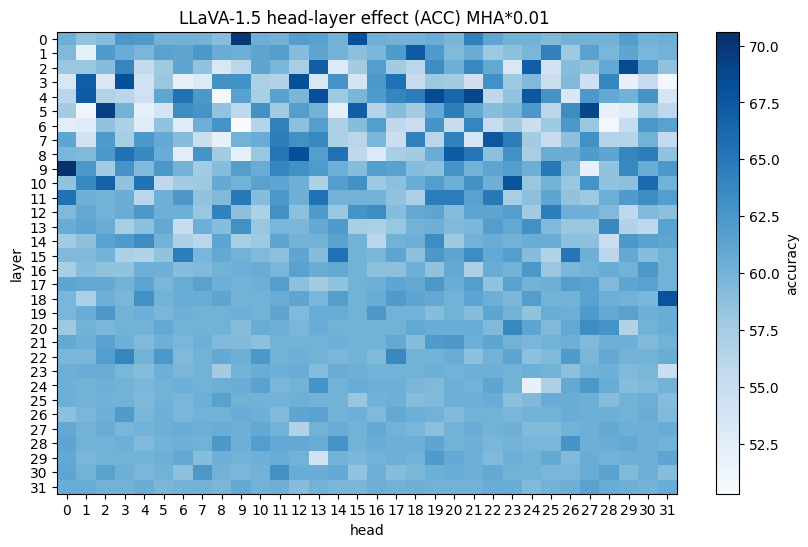

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(results)
df = df[df["method"] == "scaling_vis"]

# layer × head 피벗
pivot = df.pivot(index="layer", columns="head", values="Individual accuracy")

# 히트맵
plt.figure(figsize=(10, 6))
im = plt.imshow(pivot.values, aspect="auto",cmap="Blues")
plt.colorbar(im, label="accuracy")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("head")
plt.ylabel("layer")
plt.title("LLaVA-1.5 head-layer effect (ACC) MHA*0.01 ")
plt.show()

In [4]:
import json
import glob
import re

path_pattern = "/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/output/llava1.5_attention_entropy_head/results1.5_attention_entropy_head_layer*.json"

layer_results = {}

for file in sorted(glob.glob(path_pattern)):
    # 파일명에서 layer 번호 추출
    m = re.search(r"layer(\d+)", file)
    if not m:
        continue
    layer_idx = int(m.group(1))
    
    with open(file, "r") as f:
        lines = f.read().strip().splitlines()
        # 각 줄을 JSON으로 파싱
        data = [json.loads(line) for line in lines if line.strip()]
        layer_results[layer_idx] = data

print("총 layer 수:", len(layer_results))
print("layer 0 데이터 줄 수:", len(layer_results[0]))
print("layer 0 첫 줄:", layer_results[0][0])


총 layer 수: 32
layer 0 데이터 줄 수: 660
layer 0 첫 줄: [[0.8812487721443176, 0.9437838196754456, 0.9390726685523987, 0.7963595390319824, 0.7363801002502441, 0.9448995590209961, 0.8746899366378784, 0.5635671615600586, 0.927259624004364, 0.8066245317459106, 0.9003865122795105, 0.6764105558395386, 0.8313129544258118, 0.9379534125328064, 0.932253360748291, 0.8615995645523071, 0.9261878728866577, 0.9278115034103394, 0.8225203156471252, 0.7659057974815369, 0.9268917441368103, 0.9147036075592041, 0.8725113868713379, 0.6140789985656738, 0.5142562985420227, 0.7894021272659302, 0.8809709548950195, 0.8586615324020386, 0.929163932800293, 0.843049943447113, 0.6104681491851807, 0.9260743260383606]]


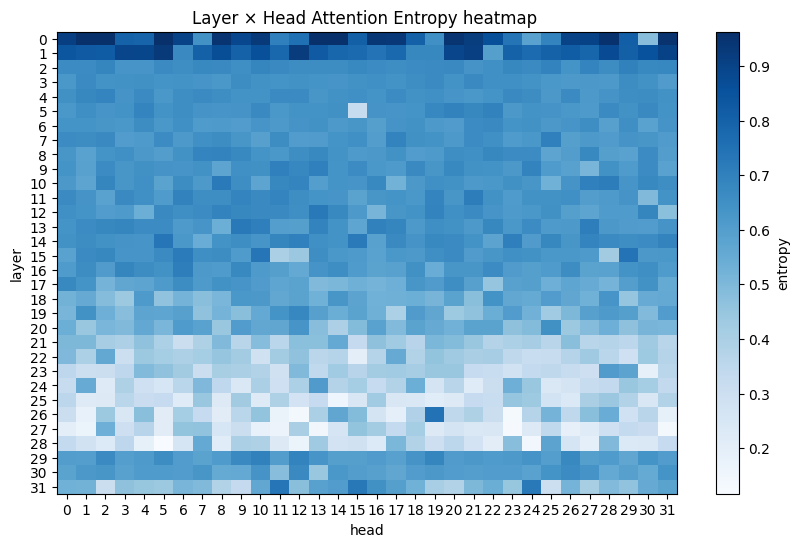

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# layer별 head 평균 (동일 index끼리 평균) entropy 
layer_means = {}
for layer, data in layer_results.items():
    arr = np.array([line[0] for line in data])   # (num_lines, 32)
    layer_means[layer] = arr.mean(axis=0)        # (32,)

# layer 0 제거 후 오름차순 정렬
layers = sorted([l for l in layer_means.keys()])
all_means = np.vstack([layer_means[l] for l in layers])  # (num_layers-1, 32)

# 히트맵 
plt.figure(figsize=(10, 6))
im = plt.imshow(all_means, aspect="auto", cmap="Blues")  # 역방향 색상
plt.colorbar(im, label="entropy")
plt.xticks(range(all_means.shape[1]), range(all_means.shape[1]))
plt.yticks(range(len(layers)), layers)
plt.xlabel("head")
plt.ylabel("layer")
plt.title("Layer × Head Attention Entropy heatmap ")
plt.show()

#할루시네이션으로 보이는 헤드의 entropy 값이 낮음 


겹치는 (layer, head) 개수: 358
전체 대비 비율: 0.350


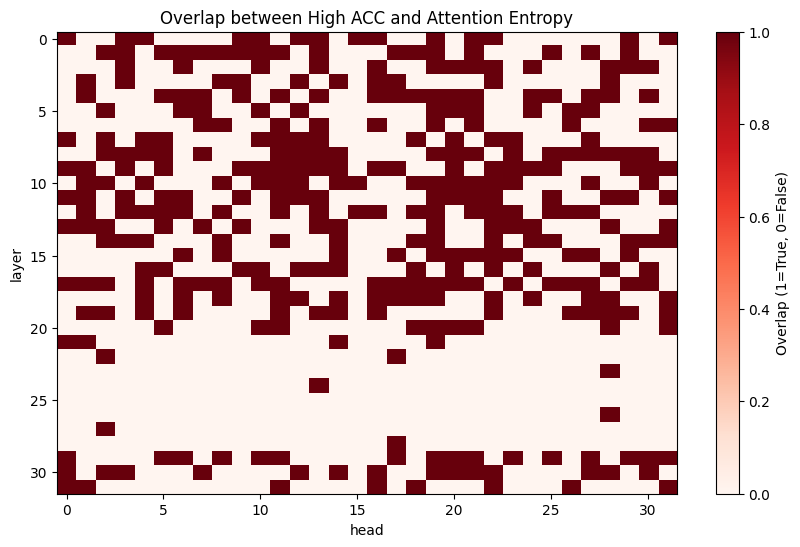

In [13]:
import numpy as np

# 1번 히트맵 값
acc_map = pivot.values              # shape: (layers, heads)

# 2번 히트맵 값
weight_map = all_means              # shape: (layers, heads)

# Threshold 설정 (원하는 값으로 바꾸세요)
acc_thresh = 60.0
weight_thresh = 0.5

# 마스크 만들기
acc_mask = acc_map > acc_thresh #할루시네이션 헤드 
weight_mask = weight_map > weight_thresh #엔트로피가 낮은 값

# 겹치는 부분
overlap_mask = acc_mask & weight_mask

# 겹치는 갯수와 비율
num_overlap = overlap_mask.sum()
total_points = overlap_mask.size
ratio = num_overlap / total_points

print(f"겹치는 (layer, head) 개수: {num_overlap}")
print(f"전체 대비 비율: {ratio:.3f}")

# 겹치는 부분 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(overlap_mask, aspect="auto", cmap="Reds")
plt.colorbar(label="Overlap (1=True, 0=False)")
plt.xlabel("head")
plt.ylabel("layer")
plt.title("Overlap between High ACC and Attention Entropy")
plt.show()


In [9]:
import json
import glob
import re

path_pattern = "/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/output/llava1.5_confidence_head_ver2/results1.5_confidence_head_layer*.json"

layer_results_confidence = {}

for file in sorted(glob.glob(path_pattern)):
    # 파일명에서 layer 번호 추출
    m = re.search(r"layer(\d+)", file)
    if not m:
        continue
    layer_idx = int(m.group(1))
    
    with open(file, "r") as f:
        lines = f.read().strip().splitlines()
        # 각 줄을 JSON으로 파싱
        data = [json.loads(line) for line in lines if line.strip()]
        layer_results_confidence[layer_idx] = data

print("총 layer 수:", len(layer_results_confidence))
print("layer 0 데이터 줄 수:", len(layer_results_confidence[0]))
print("layer 0 첫 줄:", layer_results_confidence[0][0])


총 layer 수: 32
layer 0 데이터 줄 수: 660
layer 0 첫 줄: [[0.06510086357593536, 0.021368740126490593, 0.04018073156476021, 0.08504030108451843, 0.09265011548995972, 0.031998161226511, 0.11345332860946655, 0.258959025144577, 0.03461155295372009, 0.08846147358417511, 0.05966254696249962, 0.1597372442483902, 0.0642944946885109, 0.04518134519457817, 0.06151890754699707, 0.04739385470747948, 0.052562858909368515, 0.06035933271050453, 0.09500057250261307, 0.10079716891050339, 0.03839697316288948, 0.03994240239262581, 0.0758509486913681, 0.22051599621772766, 0.32320624589920044, 0.07228127866983414, 0.07695785164833069, 0.0934458076953888, 0.03858364373445511, 0.06801066547632217, 0.23509524762630463, 0.06128225475549698]]


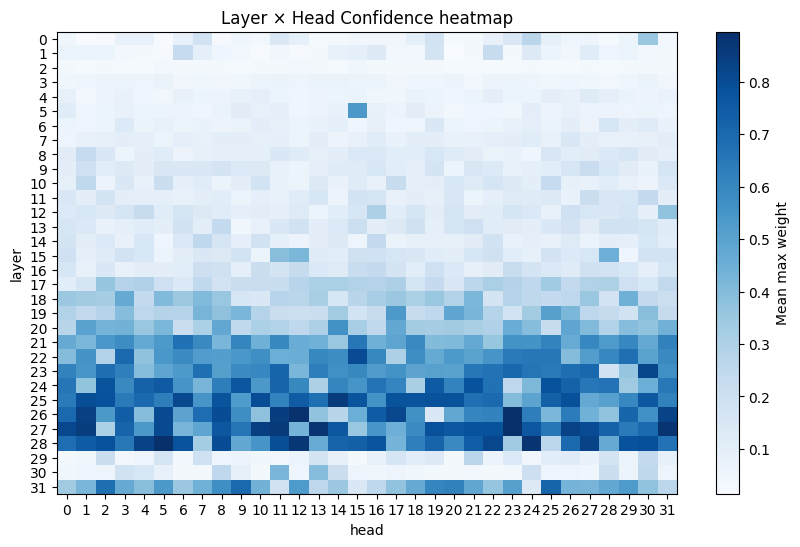

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# layer별 head 평균 (동일 index끼리 평균)
layer_means_c = {}
for layer, data in layer_results_confidence.items():
    arr = np.array([line[0] for line in data])   # (num_lines, 32)
    layer_means_c[layer] = arr.mean(axis=0)        # (32,)

# layer 0 제거 후 오름차순 정렬
layers = sorted([l for l in layer_means_c.keys()])
all_means_c = np.vstack([layer_means_c[l] for l in layers])  # (num_layers-1, 32)

# 히트맵 (색상 반전)
plt.figure(figsize=(10, 6))
im = plt.imshow(all_means_c, aspect="auto", cmap="Blues")  # 역방향 색상
plt.colorbar(im, label="Mean max weight")
plt.xticks(range(all_means_c.shape[1]), range(all_means_c.shape[1]))
plt.yticks(range(len(layers)), layers)
plt.xlabel("head")
plt.ylabel("layer")
plt.title("Layer × Head Confidence heatmap")
plt.show()

겹치는 (layer, head) 개수: 394
전체 대비 비율: 0.385


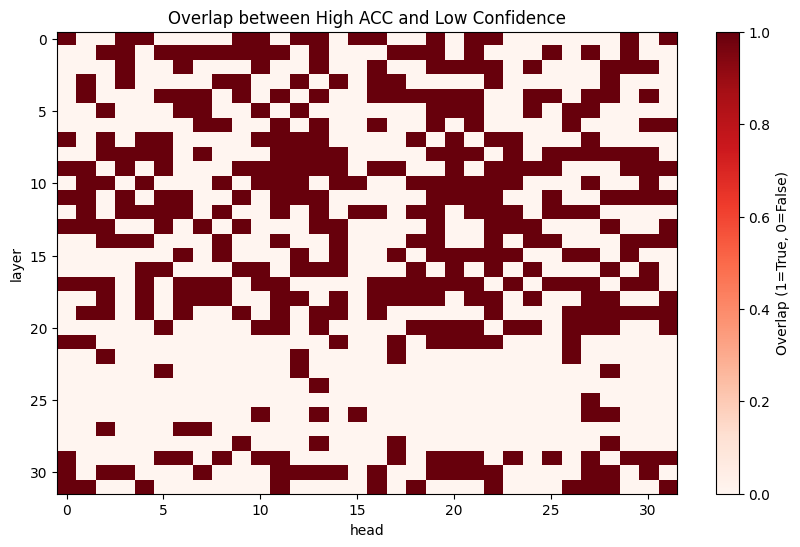

In [12]:
import numpy as np

# 1번 히트맵 값
acc_map = pivot.values              # shape: (layers, heads)

# 2번 히트맵 값
weight_map = all_means_c              # shape: (layers, heads)

# Threshold 설정 (원하는 값으로 바꾸세요)
acc_thresh = 60.0
weight_thresh = 0.5

# 마스크 만들기
acc_mask = acc_map > acc_thresh
weight_mask = weight_map < weight_thresh

# 겹치는 부분
overlap_mask = acc_mask & weight_mask

# 겹치는 갯수와 비율
num_overlap = overlap_mask.sum()
total_points = overlap_mask.size
ratio = num_overlap / total_points

print(f"겹치는 (layer, head) 개수: {num_overlap}")
print(f"전체 대비 비율: {ratio:.3f}")

# 겹치는 부분 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(overlap_mask, aspect="auto", cmap="Reds")
plt.colorbar(label="Overlap (1=True, 0=False)")
plt.xlabel("head")
plt.ylabel("layer")
plt.title("Overlap between High ACC and Low Confidence")
plt.show()
